---
title: Aggregate climate data to different time scales
short_title: Time period aggregation
---

Climate data may be collected and reported at various temporal resolutions (e.g., hourly, daily, or monthly). When preparing data for import into DHIS2, it's important to ensure that the data is aggregated appropriately to match both the type of variable and the target period.

In [1]:
import xarray as xr
from earthkit import transforms

## Aggregating hourly climate data to daily

Consider the [ERA5-Land data](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-land?tab=overview), which in its original version contains data for climatic variables for every hour since 1950. Below, we load a sample file of ERA5-Land hourly temperature and precipitation data for Sierra Leone, and subset it to only the first 3 days of February, 2025:

In [90]:
from dhis2eo.data.cds import era5_land
import geopandas as gpd
org_units = gpd.read_file('../data/sierra-leone-districts.geojson')
era5_land.hourly.download(start='2025-02', end='2025-02', bbox=org_units.total_bounds,
                          variables=['total_precipitation', '2m_temperature'],
                          dirname='../data', prefix='era5-land-hourly-temp-precip')

INFO - 2026-01-20 02:18:02,047 - dhis2eo.data.cds.era5_land.hourly - Month 2025-2
INFO - 2026-01-20 02:18:02,049 - dhis2eo.data.cds.era5_land.hourly - Downloading data from CDS API...
INFO - 2026-01-20 02:18:02,050 - dhis2eo.data.cds.era5_land.hourly - Request parameters: 
{"variable": ["total_precipitation", "2m_temperature"], "year": "2025", "month": ["02"], "day": ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20", "21", "22", "23", "24", "25", "26", "27", "28"], "time": ["00:00", "01:00", "02:00", "03:00", "04:00", "05:00", "06:00", "07:00", "08:00", "09:00", "10:00", "11:00", "12:00", "13:00", "14:00", "15:00", "16:00", "17:00", "18:00", "19:00", "20:00", "21:00", "22:00", "23:00"], "area": [10.0004, -13.3035, 6.9176, -10.2658], "data_format": "netcdf", "download_format": "unarchived"}


2026-01-20 02:18:03,140 INFO [2025-12-11T00:00:00] Please note that a dedicated catalogue entry for this dataset, post-processed and stored in Analysis Ready Cloud Optimized (ARCO) format (Zarr), is available for optimised time-series retrievals (i.e. for retrieving data from selected variables for a single point over an extended period of time in an efficient way). You can discover it [here](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-land-timeseries?tab=overview)
2026-01-20 02:18:03,141 INFO Request ID is 6b1d38d9-bf23-4785-a617-b06c249c50e6
2026-01-20 02:18:03,214 INFO status has been updated to accepted
2026-01-20 02:18:24,383 INFO status has been updated to running
2026-01-20 02:22:21,794 INFO status has been updated to successful


589b0496c0ae544a6ab3d50b5148e502.nc:   0%|          | 0.00/1.71M [00:00<?, ?B/s]

[WindowsPath('C:/Users/karimba/Documents/Github/climate-tools/docs/guides/data/era5-land-hourly-temp-precip_2025-02.nc')]

In [3]:
start = '2025-02-01'
end = '2025-02-03'
hourly = xr.open_dataset('../data/era5-land-hourly-temp-precip-feb-2025-sierra-leone.nc')
hourly = hourly.sel(valid_time=slice(start, end))
hourly

<xarray.Dataset> Size: 555kB
Dimensions:     (valid_time: 72, latitude: 31, longitude: 31)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 576B 2025-02-01 ... 2025-02-03T23...
  * latitude    (latitude) float64 248B 9.918 9.818 9.718 ... 7.118 7.018 6.917
  * longitude   (longitude) float64 248B -13.3 -13.2 -13.1 ... -10.5 -10.4 -10.3
Data variables:
    tp          (valid_time, latitude, longitude) float32 277kB ...
    t2m         (valid_time, latitude, longitude) float32 277kB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2026-01-20T01:20 GRIB to CDM+CF via cfgrib-0.9.1...

We see that our dataset contains data for 72 hours (3 days), with data values for temperature (`t2m`) and precipitation (`tp`). Such hourly data are too detailed for DHIS2, where the smallest possible period type is daily. To import them, we next show how to aggregate the hourly values to daily totals.

For the upcoming sections, we will use the capital of Sierra Leone, Freetown, as an example to illustrate the effects of temporal aggregation. We select the grid point closest to the capital to obtain an xarray with only hourly values:

In [4]:
hourly_freetown = hourly.sel(latitude=8.48, longitude=-13.23, method="nearest")

> **Important**: When aggregating hourly data to daily values, it is important to account for the local timezone so that hours are assigned to the correct calendar day. Since Sierra Leone uses the same timezone as the climate data (UTC+0), this issue is not addressed in the current notebook but will be covered in a future one.

### Temperature

Before we aggregate the hourly temperature data, let's first inspect and plot the hourly temperature values for the city of Freetown. From this, we see that the hourly temperature data is reported in kelvins, and that the temperature peaks a little past noon each day, as we would expect:

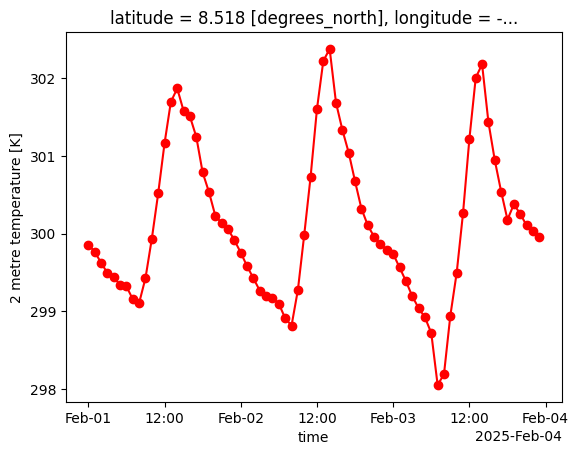

In [68]:
hourly_freetown['t2m'].plot(color='red', marker='o')

A common way to aggregate hourly to **daily temperature** values is to take the **average** temperature for each day. We can do so easily by extracting the `t2m` variable and passing that to the `temporal.daily_reduce` function from the `earthkit.transforms` module. We specify that we want the average temperature value by setting `how='mean'`: 

In [6]:
hourly_temp = hourly_freetown['t2m']
daily_temp = transforms.temporal.daily_reduce(hourly_temp, how='mean')

If we now plot the aggregated data, we see only 3 daily values, as expected. We also reuse the previous y-limits to make it comparable with the hourly chart:

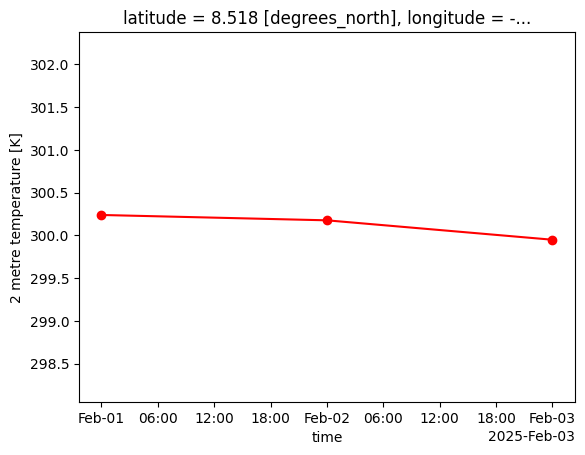

In [8]:
ymin, ymax = hourly_temp.min(), hourly_temp.max()
daily_temp.plot(color='red', marker='o', ylim=(ymin, ymax))

### Precipitation

For the precipitation data, let's do the same as we did for temperature and plot what the hourly precipitation data looks like for the city of Freetown:

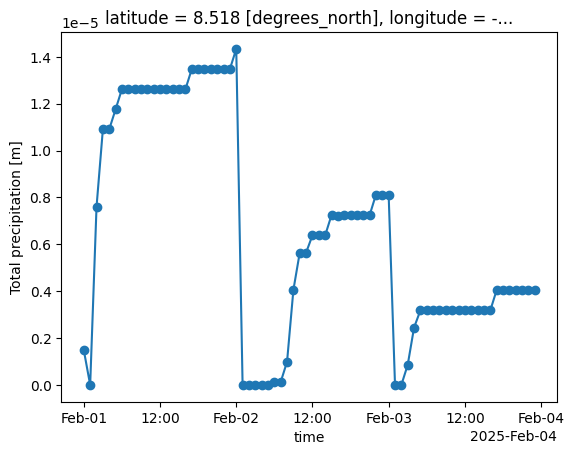

In [11]:
hourly_freetown['tp'].plot(marker='o')

This time we see that there is something strange going on. We see that the precipitation, which is reported in meters, has a curious shape that gradually increases and suddently resets at the end of each day. 

That is because the `tp` precipitation variable in ERA5-Land is provided as a daily accumulated variable, meaning each time step represents the total precipitation accumulated since the start of the day. 

To instead know how much precipitation occured **during** each hour, we need to calculate the incremental differences for each of the accumulated values: 

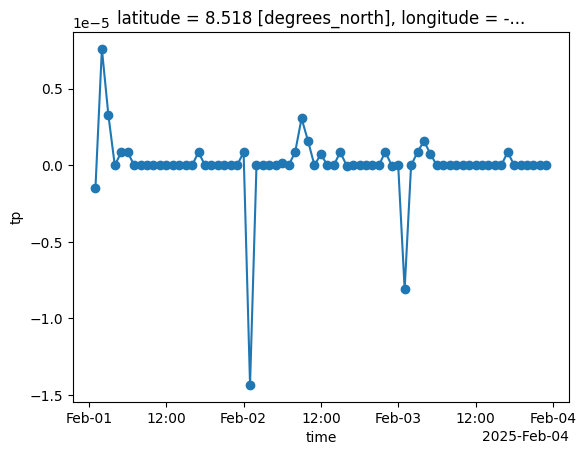

In [12]:
accum_precip = hourly_freetown['tp']
hourly_precip = accum_precip.diff(dim='valid_time')
hourly_precip.plot(marker='o')

This plot looks better, but now we see that there are negative differences at the boundary of each day when the accumulation reset. Those negative values represent the first hour of each day and can simply be replaced with the original accumulated value for those hours:

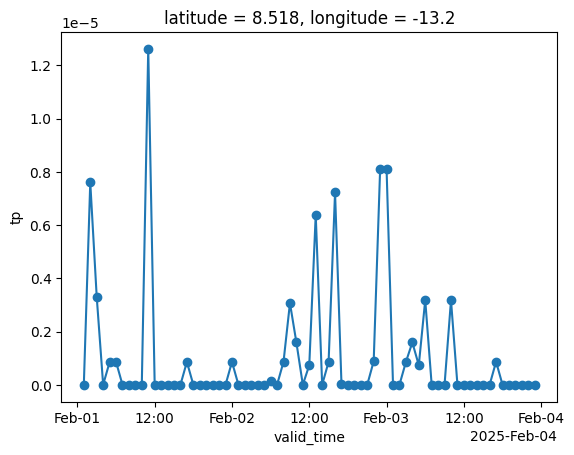

In [13]:
hourly_precip = xr.where(hourly_precip < 0, accum_precip.isel(valid_time=slice(1, None)), hourly_precip)
hourly_precip.plot(marker='o')

Now that we have the correct hourly precipitation values throughout the day, we can proceed to aggregate from hourly to **daily precipiation**. Daily precipitation is typically calculated as the **sum total** of all the precipitation that happened throughout each day. To do so, we can simply pass the hourly precipiation to `earthkit`'s `temporal.daily_reduce` function, and set `how='sum'`: 

In [14]:
daily_precip = transforms.temporal.daily_reduce(hourly_precip, how='sum')

Finally, when we plot the aggregated precipitation data, we see that February 3 had the least amount of total precipitation, matching what we saw in the hourly chart. We also see that the total daily amounts are higher than in the hourly chart, because the daily precipitation was computed as the sum of hourly precipitation: 

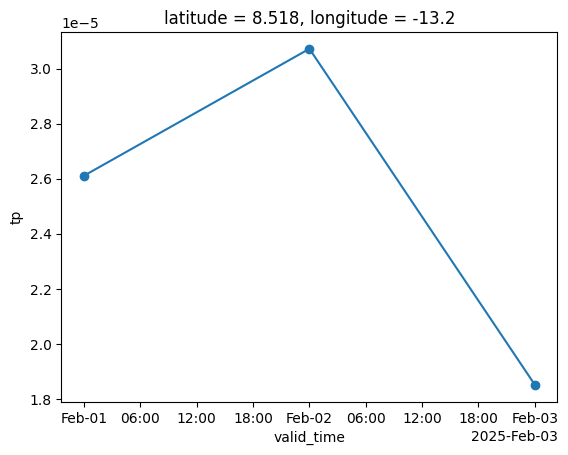

In [15]:
daily_precip.plot(marker='o')

## Aggregating daily climate data to monthly

We can apply the same approach we used for hourly-to-daily aggregation to produce **monthly summaries**. In the previous section we only looked at the first 3 days of February, so we start by loading the full sample of the same ERA5-Land dataset for February 2025:

In [19]:
hourly = xr.open_dataset('../data/era5-land-hourly-temp-precip-feb-2025-sierra-leone.nc')

Let's select and plot the hourly temperature values for the city of Freetown: 

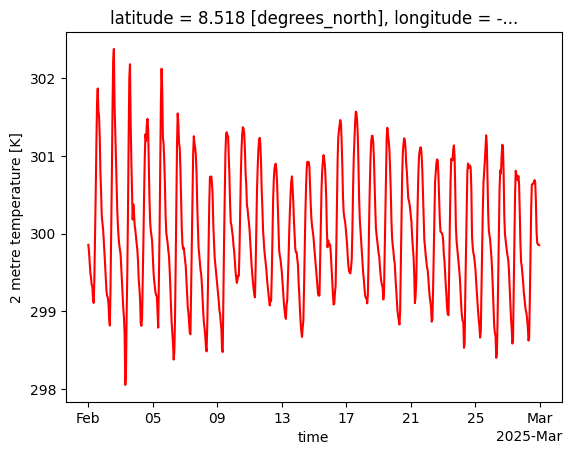

In [25]:
hourly_freetown = hourly.sel(latitude=8.48, longitude=-13.23, method="nearest")
hourly_temp = hourly_freetown['t2m']
hourly_temp.plot(color='red')

To aggregate the daily temperature data to monthly averages, we use `earthkit`'s `temporal.monthly_reduce` function:

In [22]:
monthly_temp = transforms.temporal.monthly_reduce(hourly_temp, how='mean')

Since the original data was only for the month of February, we are left with only a single monthly aggregated value:

In [23]:
monthly_temp.to_dataframe()

,latitude,longitude,t2m
valid_time,,,
2025-02-01,8.518,-13.203967,299.991333


## Next steps

In this notebook we have shown how to aggregate hourly climate data to daily data so that it can be imported into DHIS2. We have also shown how to inspect the temporal aspects of the hourly data, and how aggregation differs for temperature and precipitation variables. We also briefly showed how the same principles can be applied to aggregate daily climate data to monthly. 

Once your gridded climate data has been aggregated to the desired time period, the next step is to spatially aggregate from gridded data to DHIS2 organisation units. See our guide for [aggregating to DHIS2 organisation units](org-unit-aggregation.ipynb). 